In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import sys
import scipy as sp

# Load Datasets

In [12]:
dataset_a1_2_path = "/home/pbiel/repos/jask/analytics/reassignments/a1_2.csv"
df_a12 = pd.read_csv(dataset_a1_2_path)

# Utility Functions

In [ ]:
def get_basic_stats(df):
    print(f"\n=== BASIC STATISTICS ===")
    print(f"Total reassignments: {len(df):,}")
    print(f"Unique processes moved: {df['ProcessID'].nunique():,}")
    print(f"Unique services: {df['Service'].nunique():,}")
    print(f"Time span: {(df['Timestamp'].max() - df['Timestamp'].min()) / 1000:.2f} seconds")
    
    print(f"\n=== PROCESS SIZE ANALYSIS ===")
    print(f"Average process size: {df['ProcessSize'].mean():.0f}")
    print(f"Median process size: {df['ProcessSize'].median():.0f}")
    print(f"Min process size: {df['ProcessSize'].min():.0f}")
    print(f"Max process size: {df['ProcessSize'].max():.0f}")

    # Analyze moves per process
    moves_per_process = df['ProcessID'].value_counts()
    print(f"\n=== MOVEMENT FREQUENCY ===")
    print(f"Processes moved once: {(moves_per_process == 1).sum():,}")
    print(f"Processes moved multiple times: {(moves_per_process > 1).sum():,}")
    print(f"Most moved process: Process {moves_per_process.index[0]} with {moves_per_process.iloc[0]} moves")

    # Analyze by process size quartiles
    size_quartiles = df['ProcessSize'].quantile([0.25, 0.5, 0.75])
    print(f"\n=== MOVEMENT BY PROCESS SIZE ===")
    print(f"25th percentile size: {size_quartiles[0.25]:.0f}")
    print(f"50th percentile size: {size_quartiles[0.5]:.0f}")
    print(f"75th percentile size: {size_quartiles[0.75]:.0f}")

    # Categorize processes by size
    df['SizeCategory'] = pd.cut(
        df['ProcessSize'], 
        bins = [
            0, 
            size_quartiles[0.25], 
            size_quartiles[0.5],
            size_quartiles[0.75], 
            float('inf')
        ],
        labels = [
            'Small', 
            'Medium', 
            'Large', 
            'XLarge'
        ]
    )
    
    size_movement_count = df.groupby('SizeCategory').size()
    print("\nMovements by size category:")
    for category, count in size_movement_count.items():
        print(f"  {category}: {count:,} moves ({count/len(df)*100:.1f}%)")
    
    # Analyze improvement over time
    print(f"\n=== IMPROVEMENT ANALYSIS ===")
    print(f"Initial improvement: {df['Improvement'].iloc[0]:.4f}%")
    print(f"Final improvement: {df['Improvement'].iloc[-1]:.4f}%")
    print(f"Total improvement gain: {df['Improvement'].iloc[-1] - df['Improvement'].iloc[0]:.4f}%")
    
    # Analyze move cost distribution
    print(f"\n=== MOVE COST ANALYSIS ===")
    print(f"Average move cost: {df['MoveCost'].mean():.2f}")
    print(f"Median move cost: {df['MoveCost'].median():.2f}")
    print(f"Move cost distribution:")
    move_cost_counts = df['MoveCost'].value_counts().sort_index()
    for cost, count in move_cost_counts.head(10).items():
        print(f"  Cost {cost}: {count:,} moves ({count/len(df)*100:.1f}%)")
    
    # Analyze temporal patterns
    print(f"\n=== TEMPORAL PATTERNS ===")
    df['TimeFromStart'] = (df['Timestamp'] - df['Timestamp'].min()) / 1000  # Convert to seconds
    
    # Divide into time periods
    time_periods = pd.cut(df['TimeFromStart'], bins=5, labels=['Period1', 'Period2', 'Period3', 'Period4', 'Period5'])
    period_stats = df.groupby(time_periods).agg({
        'ProcessSize': 'mean',
        'MoveCost': 'mean',
        'ProcessID': 'count'
    })
    
    print("\nAverage process size moved per time period:")
    for period, stats in period_stats.iterrows():
        print(f"  {period}: {stats['ProcessSize']:.0f} (avg size), {stats['ProcessID']:,} moves")

# Exploration

In [ ]:
def get_requirements(df):

    def parse_requirements(req_str):
        try:
            return ast.literal_eval(req_str)
        except:
            return [0, 0, 0, 0]
        
    df['Requirements'] = df['Requirements'].apply(parse_requirements)
    df['ProcessSize'] = df['Requirements'].apply(sum)

    # Extract each of the four requirements
    df[['Req1', 'Req2', 'Req3', 'Req4']] = pd.DataFrame(df['Requirements'].tolist(), index=df.index)
    return df

df_a12 = get_requirements(df_a12)
df_a12.head()

,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,Requirements,Improvement,Timestamp,Requirements_List,ProcessSize,Req1,Req2,Req3,Req4
0,1,138,53,76,53,141,1,"[621123, 391575, 25988, 3787006]",0.0000,1752443433287,"[621123, 391575, 25988, 3787006]",4825692,621123,391575,25988,3787006
1,2,759,53,71,53,749,1,"[810461, 876255, 311104, 659257]",2.4285,1752443433292,"[810461, 876255, 311104, 659257]",2657077,810461,876255,311104,659257
2,3,759,71,53,53,749,1,"[810461, 876255, 311104, 659257]",1.2379,1752443433294,"[810461, 876255, 311104, 659257]",2657077,810461,876255,311104,659257
3,4,780,47,60,47,769,1,"[386106, 346913, 22844, 1338795]",2.4285,1752443433294,"[386106, 346913, 22844, 1338795]",2094658,386106,346913,22844,1338795
4,5,550,47,71,47,542,1,"[399471, 511495, 97396, 962662]",3.8310,1752443433296,"[399471, 511495, 97396, 962662]",1971024,399471,511495,97396,962662


In [ ]:
# Get min, mean, max of each requirement
def get_requirement_stats(df):

    stats = {
        'Req1': {'min': df['Req1'].min(), 'mean': df['Req1'].mean(), 'max': df['Req1'].max()},
        'Req2': {'min': df['Req2'].min(), 'mean': df['Req2'].mean(), 'max': df['Req2'].max()},
        'Req3': {'min': df['Req3'].min(), 'mean': df['Req3'].mean(), 'max': df['Req3'].max()},
        'Req4': {'min': df['Req4'].min(), 'mean': df['Req4'].mean(), 'max': df['Req4'].max()}
    }
    return stats

req_stats = get_requirement_stats(df_a12)
print("\nRequirement statistics:")
for col, stat in req_stats.items():
    print(f"{col}: Min = {stat['min']}, Mean = {stat['mean']:.2f}, Max = {stat['max']}")


Requirement statistics:
Req1: Min = 903, Mean = 22837.19, Max = 810461
Req2: Min = 554, Mean = 23268.45, Max = 1161014
Req3: Min = 1005, Mean = 44327.76, Max = 987294
Req4: Min = 145, Mean = 28178.84, Max = 3787006


In [36]:
# Get min, mean, max of each requirement
def get_requirement_stats(df):
    req_df = pd.DataFrame(df['Requirements'].tolist())
    stats = {}
    for col in req_df.columns:
        stats[col] = {
            'min': req_df[col].min(),
            'mean': req_df[col].mean(),
            'max': req_df[col].max()
        }
    print("\nRequirement statistics:")
    for col, stat in stats.items():
        print(f"{col}: Min = {stat['min']}, Mean = {stat['mean']:.2f}, Max = {stat['max']}")

    return stats

req_stats = get_requirement_stats(df_a12)


Requirement statistics:
0: Min = 903, Mean = 22837.19, Max = 810461
1: Min = 554, Mean = 23268.45, Max = 1161014
2: Min = 1005, Mean = 44327.76, Max = 987294
3: Min = 145, Mean = 28178.84, Max = 3787006


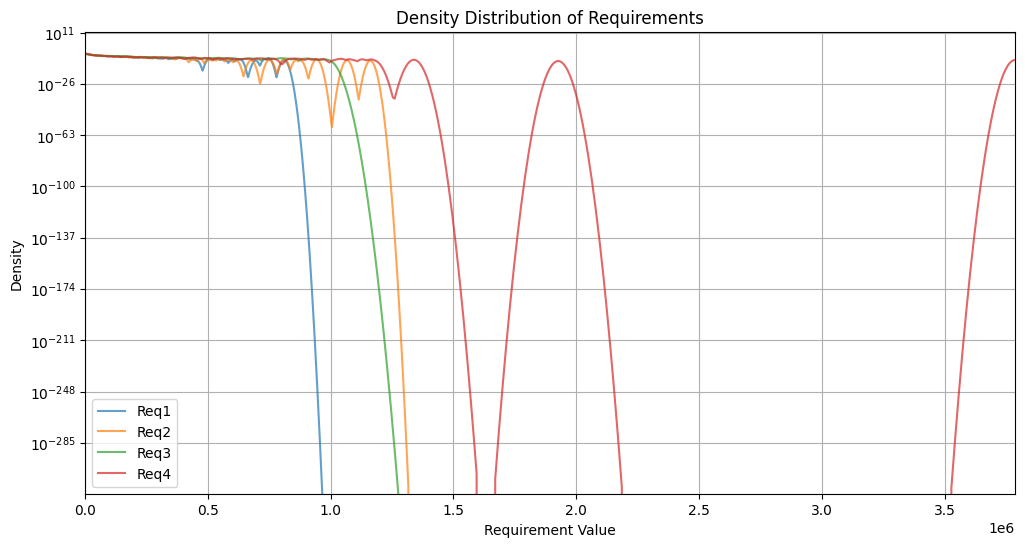

In [ ]:
# Plot density distribution of each requirement with log-log axes and x starting at 0
def plot_requirement_density(df):
    req_df = pd.DataFrame(df['Requirements'].tolist())
    
    plt.figure(figsize=(12, 6))
    for col in req_df.columns:
        req_df[col].plot(
            kind  = 'density',
            label = f'Req{col+1}',
            alpha = 0.7
        )
    
    plt.title('Density Distribution of Requirements')
    plt.xlabel('Requirement Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.xlim(left=0, right=req_df.max().max())
    plt.yscale('log')
    plt.show()

plot_requirement_density(df_a12)

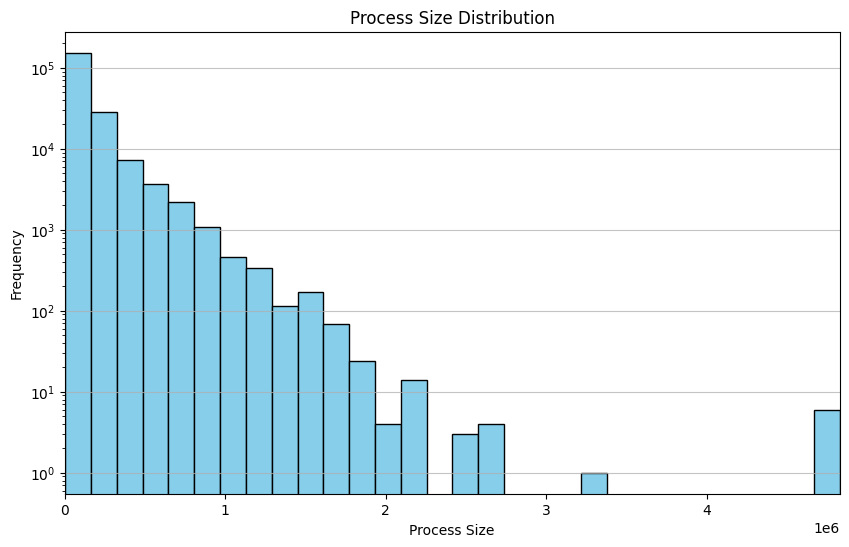

In [43]:
# Plot process size distribution with x-axis limited to max value
p_size = df_a12['ProcessSize']
plt.figure(figsize=(10, 6))
plt.hist(p_size, bins=30, color='skyblue', edgecolor='black')
plt.title('Process Size Distribution')
plt.xlabel('Process Size')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(left=0, right=p_size.max())
plt.yscale('log')
plt.show()

In [ ]:
# Iterate through each df row and plot process size over time
def plot_process_size_over_time(df):
    plt.figure(figsize=(12, 6))
    for reassignment_index, row in df.iterrows():
        plt.plot(reassignment_index, row['ProcessSize'], marker='o', alpha=0.5)
    
    plt.title('Process Size Over Time')
    plt.xlabel('Index')
    plt.ylabel('Process Size')
    plt.grid()
    plt.show()

# Dataset A

In [ ]:
get_basic_stats(df_a12)


=== BASIC STATISTICS ===
Total reassignments: 197,179
Unique processes moved: 881
Unique services: 862
Time span: 32.09 seconds

=== PROCESS SIZE ANALYSIS ===
Average process size: 118612
Median process size: 56335
Min process size: 3244
Max process size: 4825692

=== MOVEMENT FREQUENCY ===
Processes moved once: 4
Processes moved multiple times: 877
Most moved process: Process 362 with 591 moves

=== MOVEMENT BY PROCESS SIZE ===
25th percentile size: 24141
50th percentile size: 56335
75th percentile size: 149299

Movements by size category:
  Small: 49,436 moves (25.1%)
  Medium: 49,225 moves (25.0%)
  Large: 49,234 moves (25.0%)
  XLarge: 49,284 moves (25.0%)

=== IMPROVEMENT ANALYSIS ===
Initial improvement: 0.0000%
Final improvement: 26.7605%
Total improvement gain: 26.7605%

=== MOVE COST ANALYSIS ===
Average move cost: 1.00
Median move cost: 1.00
Move cost distribution:
  Cost 1: 197,179 moves (100.0%)

=== TEMPORAL PATTERNS ===

Average process size moved per time period:
  Peri

/tmp/ipykernel_8659/266750007.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_movement_count = df.groupby('SizeCategory').size()
/tmp/ipykernel_8659/266750007.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_stats = df.groupby(time_periods).agg({
